In [1]:
import networkx as nx
import numpy as np
import sys
from heapdict import *

sys.path.insert(0, '../Scripts/')
from models.ppm import PPM
from models.hsbm import HSBM
from graph_manager.plot_tools import *
from dendrogram_manager.plot_tools import *
from clustering_algorithms.paris import *

## Dendrogram compression

In [2]:
class ClusterMultTree:
    def __init__(self, cluster_label, distance, pi, sum_p_ab, sum_pi_a_pi_b):
        self.cluster_label = cluster_label
        self.merged_clusters = set([cluster_label])
        self.d_ab = distance
        self.pi = pi
        self.sum_pi_a_pi_b = sum_pi_a_pi_b
        self.sum_p_ab = sum_p_ab
        self.up_merge_loss = float('inf')
        self.up_merge_d_ab = None
        self.father = None
        self.children = set([])


def information_compresser(graph, dendrogram, n_level_merges):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1
    compressed_dendrogram = dendrogram.copy()

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight

    # Build the ClusterMultTree
    u = n_nodes
    cluster_trees = {t: ClusterMultTree(t, None, w[t]/float(wtot), 0., 0.) for t in range(n_nodes)}
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])

        # Building of the new level
        left_tree = cluster_trees[a]
        right_tree = cluster_trees[b]
        pi_a = left_tree.pi
        pi_b = right_tree.pi

        w[u] = w.pop(a) + w.pop(b)
        pi = w[u] / float(wtot)
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
        else:
            p_ab = 0
        d_ab = pi_a * pi_b / float(p_ab)
        new_tree = ClusterMultTree(u, d_ab, pi, p_ab, pi_a * pi_b)
        new_tree.children.add(left_tree)
        left_tree.father = new_tree
        new_tree.children.add(right_tree)
        right_tree.father = new_tree
        cluster_trees[u] = new_tree

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1

    # Compute the information loss of each possible merge
    u = 2 * n_nodes - 2
    merging_priority = heapdict()
    for t in list(reversed(range(n_nodes - 1))):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])

        left_tree = cluster_trees[a]
        right_tree = cluster_trees[b]

        current_tree = cluster_trees[u]
        d_ab = current_tree.d_ab
        p_ab = current_tree.sum_p_ab
        pi_a_pi_b = current_tree.sum_pi_a_pi_b

        # Loss computation with left level
        if left_tree.d_ab is not None:
            left_d_ab = left_tree.d_ab
            left_p_ab = left_tree.sum_p_ab
            left_pi_a_pi_b = left_tree.sum_pi_a_pi_b

            left_tree.up_merge_d_ab = (pi_a_pi_b + left_pi_a_pi_b) / float(p_ab + left_p_ab)
            left_tree.up_merge_loss = (p_ab + left_p_ab) * np.log(left_tree.up_merge_d_ab) - (p_ab * np.log(d_ab) + left_p_ab * np.log(left_d_ab))
            
            merging_priority[left_tree.cluster_label] = left_tree.up_merge_loss

        # Loss computation with right level
        if right_tree.d_ab is not None:
            right_d_ab = right_tree.d_ab
            right_p_ab = right_tree.sum_p_ab
            right_pi_a_pi_b = right_tree.sum_pi_a_pi_b

            right_tree.up_merge_d_ab = (pi_a_pi_b + right_pi_a_pi_b) / float((p_ab + right_p_ab))
            right_tree.up_merge_loss = (p_ab + right_p_ab) * np.log(right_tree.up_merge_d_ab) - (p_ab * np.log(d_ab) + right_p_ab * np.log(right_d_ab))

            merging_priority[right_tree.cluster_label] = right_tree.up_merge_loss

        u -= 1

    # Merge n_levels times
    for n_merges in range(n_level_merges):
        cluster_label, minimum_loss = merging_priority.popitem()

        merged_tree = cluster_trees[cluster_label]
        father_merged_tree = merged_tree.father

        # Merge the two levels
#        print(father_merged_tree.d_ab, merged_tree.up_merge_d_ab, merged_tree.d_ab)
        father_merged_tree.sum_pi_a_pi_b += merged_tree.sum_pi_a_pi_b
        father_merged_tree.sum_p_ab += merged_tree.sum_p_ab
        father_merged_tree.d_ab = merged_tree.up_merge_d_ab
        father_merged_tree.merged_clusters |= merged_tree.merged_clusters
        father_merged_tree.children |= merged_tree.children
        father_merged_tree.children.remove(merged_tree)

        for c in father_merged_tree.merged_clusters:
            cluster_trees[c].d_ab = father_merged_tree.d_ab
#            compressed_dendrogram[cluster_trees[c].cluster_label - n_nodes, 2] = father_merged_tree.d_ab

        # Updates the father and the children loss
        if father_merged_tree.father is not None:
            pi_a_pi_b = father_merged_tree.sum_pi_a_pi_b
            p_ab = father_merged_tree.sum_p_ab
            d_ab = father_merged_tree.d_ab
            father_pi_a_pi_b = father_merged_tree.father.sum_pi_a_pi_b
            father_p_ab = father_merged_tree.father.sum_p_ab
            father_d_ab = father_merged_tree.father.d_ab

            father_merged_tree.up_merge_d_ab = (pi_a_pi_b + father_pi_a_pi_b) / float((p_ab + father_p_ab))
            father_merged_tree.up_merge_loss = (p_ab + father_p_ab) * np.log(father_merged_tree.up_merge_d_ab) - (p_ab * np.log(d_ab) + father_p_ab * np.log(father_d_ab))

            merging_priority[father_merged_tree.cluster_label] = father_merged_tree.up_merge_loss

        for child in father_merged_tree.children:
            if child.d_ab is not None:
                pi_a_pi_b = father_merged_tree.sum_pi_a_pi_b
                p_ab = father_merged_tree.sum_p_ab
                d_ab = father_merged_tree.d_ab
                child_pi_a_pi_b = child.sum_pi_a_pi_b
                child_p_ab = child.sum_p_ab
                child_d_ab = child.d_ab

                child.up_merge_d_ab = (pi_a_pi_b + child_pi_a_pi_b) / float((p_ab + child_p_ab))
                child.up_merge_loss = (p_ab + child_p_ab) * np.log(child.up_merge_d_ab) - (p_ab * np.log(d_ab) + child_p_ab * np.log(child_d_ab))

                child.father = father_merged_tree

                merging_priority[child.cluster_label] = child.up_merge_loss
    
    label_distance = {}
    for cluster_label, cluster_tree in cluster_trees.items():
        if cluster_tree.d_ab is not None:
            label_distance[cluster_label] = cluster_tree.d_ab
        else:
            label_distance[cluster_label] = 0.
    sorted_labels = sorted(label_distance.keys(), key=lambda label: label_distance[label])
    new_labels = {old_label: new_label for new_label, old_label in enumerate(sorted_labels)}
    
    compressed_dendrogram = np.zeros(dendrogram.shape)
    for old_label, new_label in new_labels.items():
        if old_label > n_nodes - 1:
            a = dendrogram[old_label - n_nodes][0]
            b = dendrogram[old_label - n_nodes][1]
            distance = cluster_trees[old_label].d_ab
            n = dendrogram[old_label - n_nodes][3]

            compressed_dendrogram[new_label - n_nodes] = [new_labels[a], new_labels[b], distance, n]
    
    return compressed_dendrogram
    #return reorder_dendrogram(compressed_dendrogram)


def reorder_dendrogram(D):
    n = np.shape(D)[0] + 1
    order = np.zeros((2, n - 1), float)
    order[0] = range(n - 1)
    order[1] = np.array(D)[:, 2]
    index = np.lexsort(order)
    nindex = {i: i for i in range(n)}
    nindex.update({n + index[t]: n + t for t in range(n - 1)})
    return np.array([[nindex[int(D[t][0])], nindex[int(D[t][1])], D[t][2], D[t][3]] for t in range(n - 1)])[index, :]

## PPM

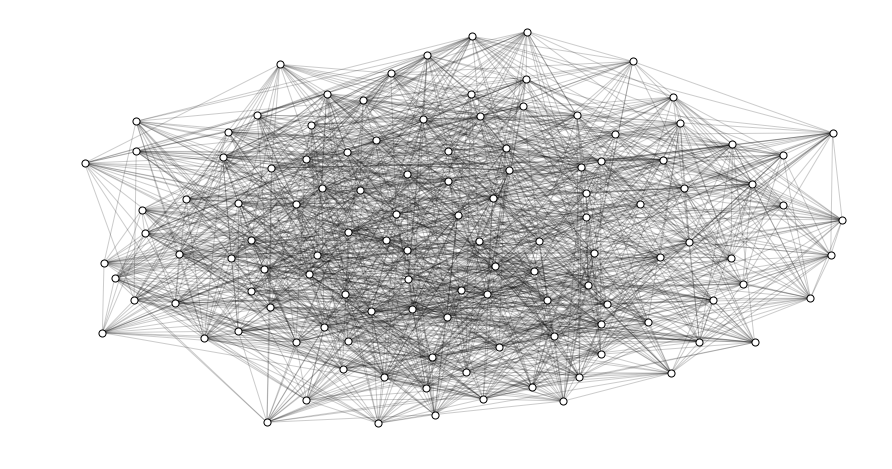

In [12]:
ppm = PPM([20, 20, 20, 20, 20, 20], .5, .1)
#ppm = PPM([100, 100], .5, .01)
ppm_graph = ppm.create_graph(distribution="Poisson")
pos = nx.spring_layout(ppm_graph)
plot_graph(ppm_graph, pos)

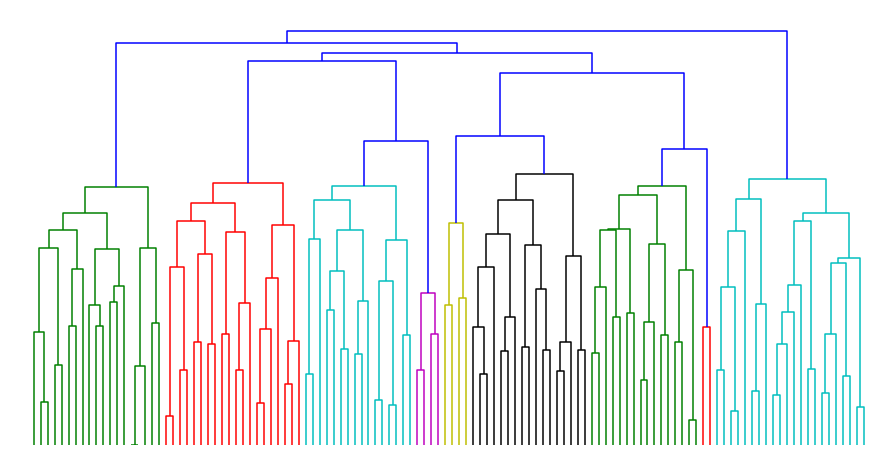

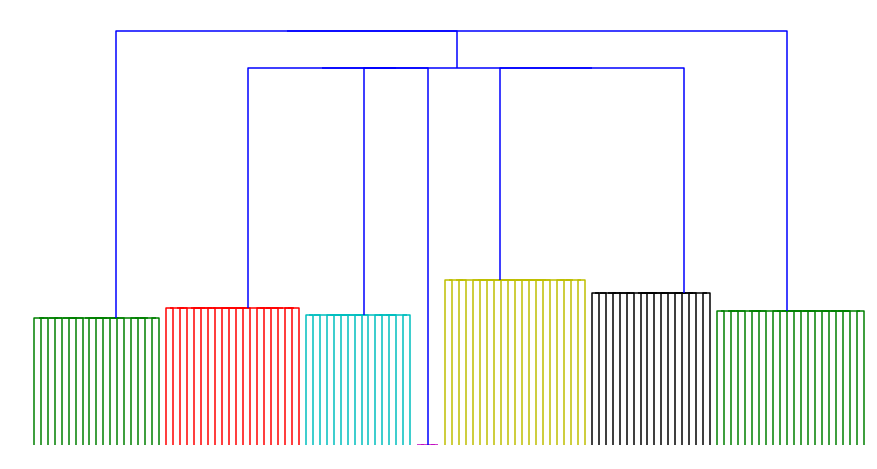

In [14]:
ppm_dendrogram = paris(ppm_graph)
plot_dendrogram(ppm_dendrogram)

ppm_compressed = information_compresser(ppm_graph, ppm_dendrogram, 110)
#print(ppm_compressed)
plot_dendrogram(ppm_compressed)

## HSBM

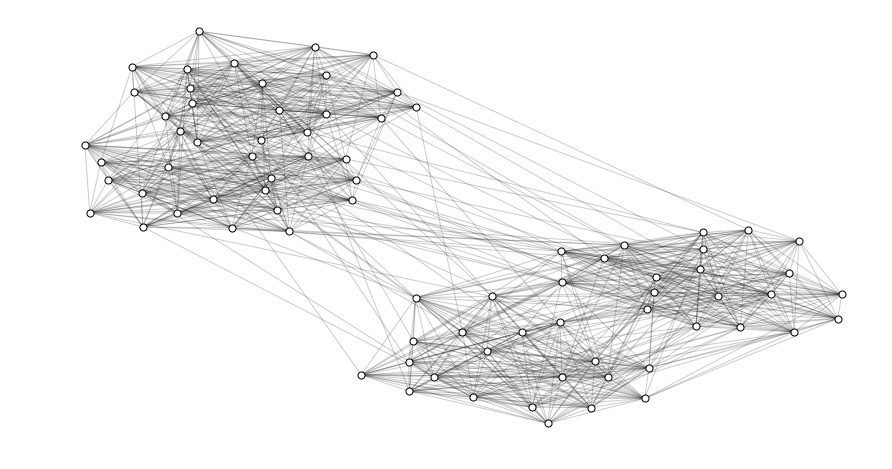

In [5]:
hsbm = HSBM.balanced(n_levels=2, decay_factor=.2, division_factor=2, core_community_size=20, p_in=1.)
hsbm_graph = hsbm.create_graph(distribution='Binomial')
pos = nx.spring_layout(hsbm_graph)
plot_graph(hsbm_graph, pos)

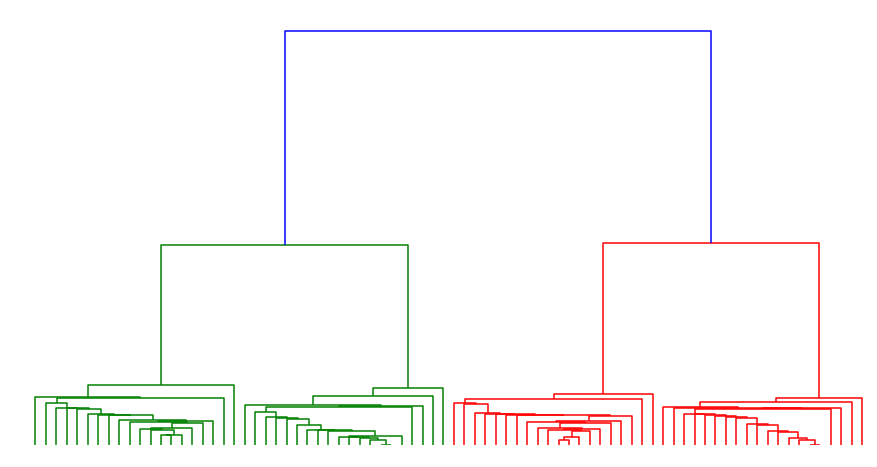

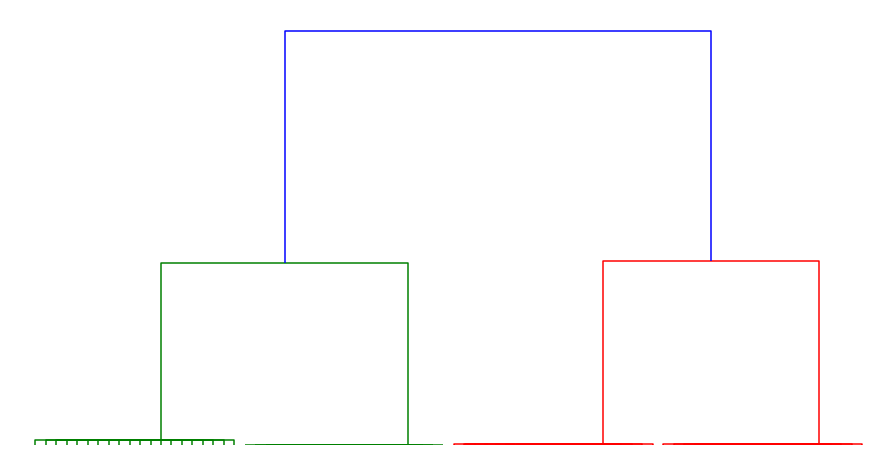

In [6]:
hsbm_dendrogram = paris(hsbm_graph)
plot_dendrogram(hsbm_dendrogram)

hsbm_compressed = information_compresser(hsbm_graph, hsbm_dendrogram, 72)
plot_dendrogram(hsbm_compressed)